#The workflow
As we discussed in the lecture, this is workflow:
- Make a model for your data
- Choose a scoring method
- Choose a cutoff above/below which the points are anomalies
- Look at these anomalies and see if the analysis makes sense


##Z-score
We will examine student participation in standardized testing. Specifically, we will look at student participation rates in the SAT in Connecticut school districts in 2012. The raw data is available here:
https://catalog.data.gov/dataset/sat-district-participation-and-performance-2012-2013
The data was cleaned so that missing values were removed, percentages were converted into decimals and only essential data for 2012 was retained.
The goal of this section is to identify schools with low participation rates as a first step in helping these schools improve their participation rates.
Load the data as a pandas dataframe and take a look at it.

In [ ]:
%matplotlib inline

import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

In [ ]:
ct_test = pd.read_csv('/content/SAT_CT_District_Participation_2012.csv')
print(ct_test.shape)
ct_test.head()

(130, 2)


,District,Participation Rate
0,Ansonia,0.66
1,Avon,0.90
2,Berlin,0.81
3,Bethel,0.86
4,Bloomfield,0.81


There are 130 schools. For convenience we will use the index number as a numeric label for each school district and use the name when appropriate.
We are going to start by assuming that the data can be modeled with a normal distribution (we will check this later). And we will use the z-score to identify anomalies. As we are concerned about low participation rates, our cutoff will be a negative number---we are looking for schools with participation rates below the mean. Here we choose z=−2
. That is, any school with a z-score below -2 will be labeled as an anomaly.
If the participation rates are indeed distributed normally, then 95% of the data should be within two standard deviations of the mean. In other words, the anomalies for our threshold lie in the 2.5% left tail of the distribution.
Note that for bigger datasets, larger absolute values of z
 (typically z=3
) are often used as a threshold. Because we have a small dataset, a large value of z
 might lead to no data being labeled as an anomaly. Also, we were conservative in our choice of z
 because we want to help as many schools as possible.
We could just go ahead and calculate the z-score for the participation rate, but it is good practice to look at fundamental statistics first. Let's calculate the mean and standard deviation. Since the data forms the whole population, we will report the population standard deviation (as opposed to the sample standard deviation)

In [ ]:
mean_rate = ct_test['Participation Rate'].mean()


# ddof is the degrees of freedom correction
# in the calculation of the standard deviation;
# for population standard deviation ddof=0
stdev_rate = ct_test['Participation Rate'].std(ddof=0)


In [ ]:
print('Mean participation rate is {:.3f}'.format(mean_rate))
print('Standard deviation is {:.3f}'.format(stdev_rate))

Mean participation rate is 0.741
Standard deviation is 0.136


Calculate the z-score and add the result to the dataframe.

In [ ]:
zscore_rate = ss.zscore(ct_test['Participation Rate'], ddof=0)
ct_test = ct_test.assign(zscore=zscore_rate)
ct_test.head(8)

,District,Participation Rate,zscore
0,Ansonia,0.66,-0.593779
1,Avon,0.90,1.175649
2,Berlin,0.81,0.512113
3,Bethel,0.86,0.880744
4,Bloomfield,0.81,0.512113
5,Bolton,0.85,0.807018
6,Branford,0.77,0.217209
7,Bridgeport,0.58,-1.183589


Now identify the anomalies and plot the results.

In [ ]:
def plot_anomaly(score_data, threshold):
    # Mask to plot values above and below threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data < threshold)


    plt.figure(dpi=150)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='OK schools')
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. school district', fontweight='bold')
    plt.xlabel('Ranked School district')
    plt.ylabel('Z-score')
    plt.show()

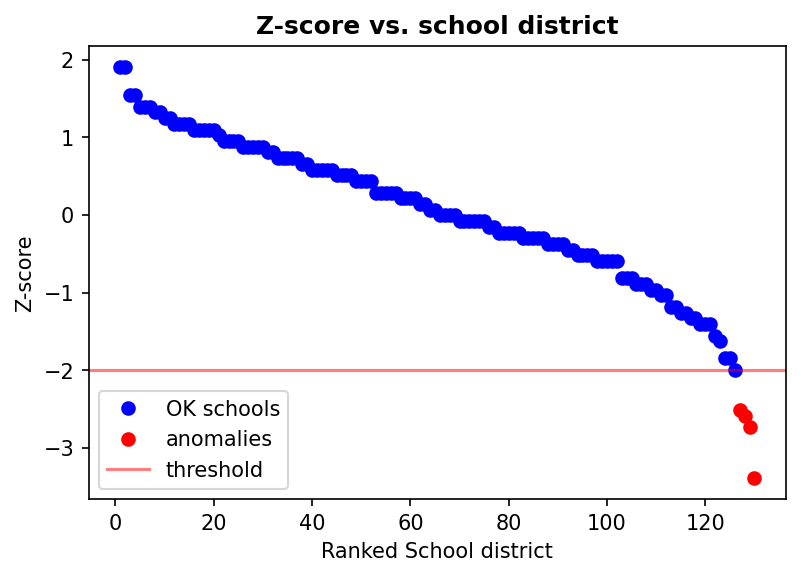

In [ ]:
plot_anomaly(ct_test['zscore'], -2)

Finally, get a list of the schools that are anomalies.

In [ ]:
zscore_anomalies = ct_test[(ct_test['zscore'] < -2)]
zscore_anomalies

,District,Participation Rate,zscore
50,New Britain,0.40,-2.510660
99,Windham,0.37,-2.731839
121,Eastern Connecticut Regional Educational Servi...,0.39,-2.584386
125,Stamford Academy,0.28,-3.395374


We have found our anomalies, but we still have one thing to do: check our assumption that the data can be modeled approximately as a normal distribution. If this is the case, then we have completed our test. If it isn't, then we cannot connect the z-score with probabilities as we did earlier in this notebook.
First, let's bin the data and see what it looks like as a histogram.

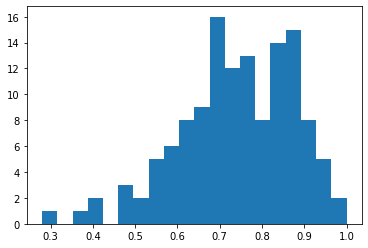

In [ ]:
nbins= 20
n_hist, bins_hist, patches_hist = plt.hist(ct_test['Participation Rate'], nbins, density=False,
                           cumulative=False, linewidth=1.0, label='data')

This histogram has two maxima and is skewed left, so it is not likely to be normal.

We can also compare the cumulative distribution function for our data with the CDF of a normal distribution with the same mean and standard deviation of our data.

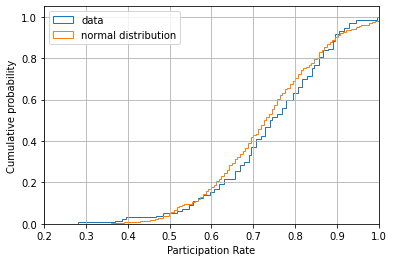

In [ ]:
num_bins = 130
normal_dist = [random.gauss(mean_rate, stdev_rate) for _ in range(500)]
n, bins, patches = plt.hist(ct_test['Participation Rate'], num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='data')
plt.hist(normal_dist, num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='normal distribution')
plt.grid(True)
plt.legend(loc='upper left')
axes = plt.gca()
axes.set_xlim([0.2,1.0])
plt.xlabel('Participation Rate')
plt.ylabel('Cumulative probability')
plt.show()

##Z-Score vs. Modified Z-Score—World Cup Top Goal Scorers
We will now look at a dataset that shows the limitations of z-scores and why the modified z-score can be useful.
We will at the number of goals scored by the top goalscorer in every World Cup from 1930 through 2018 (21 competitions in total). The raw data is from here:
https://en.wikipedia.org/wiki/FIFA_World_Cup_top_goalscorers
The data was cleaned and saved as a CSV. Load it as a dataframe and take a look.

In [ ]:
# First row is a header row, but the header names are cumbersome.
# Skip first row and manually label
# Encoding ensures that accents in sames are rendered properly
top_goals = pd.read_csv('/content/world_cup_top_goal_scorers.csv',
                        encoding='utf-8',
                        names=['Year', 'Player(s)', 'Goals'], skiprows=1)
top_goals

,Year,Player(s),Goals
0,1930,Guillermo Stábile,8
1,1934,Oldřich Nejedlý,5
2,1938,Leônidas,7
3,1950,Ademir,8
4,1954,Sándor Kocsis,11
5,1958,Just Fontaine,13
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4
7,1966,Eusébio,9
8,1970,Gerd Müller,10
9,1974,Grzegorz Lato,7


Once again will start by using the z-score to identify anomalies. As we are interested in the superstars, this time we will have an upper threshold. We choose  z=+2
 . Above this z-score, any player will be labeled as an anomaly.
As before, we calculate the mean and standard deviation.

In [ ]:
mean_goals = top_goals['Goals'].mean()
stdev_goals = top_goals['Goals'].std(ddof=0)
print('Mean number of goals is {:.2f}'.format(mean_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

Mean number of goals is 7.05
Standard deviation is 2.15


Calculate the z-score for each player and add the result to the dataframe.

In [ ]:
zscore_goals = ss.zscore(top_goals['Goals'], ddof=0)
top_goals = top_goals.assign(zscore=zscore_goals)
top_goals.head(21)

,Year,Player(s),Goals,zscore
0,1930,Guillermo Stábile,8,0.443242
1,1934,Oldřich Nejedlý,5,-0.952971
2,1938,Leônidas,7,-0.022162
3,1950,Ademir,8,0.443242
4,1954,Sándor Kocsis,11,1.839455
5,1958,Just Fontaine,13,2.770264
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4,-1.418375
7,1966,Eusébio,9,0.908647
8,1970,Gerd Müller,10,1.374051
9,1974,Grzegorz Lato,7,-0.022162


Now, modify the previous plotting function to display the results.

In [ ]:
def plot_anomaly_goals(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)

    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold,color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player Rank')
    plt.ylabel('Z-score')
    plt.show()

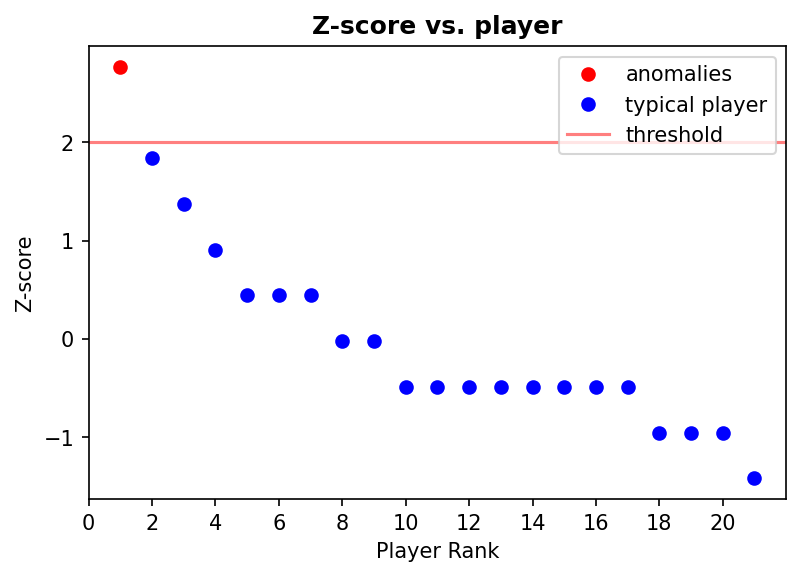

In [ ]:
plot_anomaly_goals(top_goals['zscore'], 2)

Only one player is picked out: Just Fontaine.

In [ ]:
zscore_anomalies_players = top_goals[(top_goals['zscore'] > 2)]
zscore_anomalies_players

,Year,Player(s),Goals,zscore
5,1958,Just Fontaine,13,2.770264


Fontaine was indeed an amazing player, but clearly our analysis is flawed. By looking at the plot, we see that in 12 out of 21 competitions, the top goalscorer(s) scored less than the mean number of goals (7.05).

Question: What's going on?

Answer: the mean and standard deviation are themselves susceptible to the presence of anomalies. With his 13 goals, the amazing Fontaine is raising the mean so much that most players fall below it. As a result, he becomes the only anomaly.
Let's repeat this analysis with the modified z-score and see what happens.

In [ ]:
median_goals = np.median(top_goals['Goals'])
median_goals

6.0

Note that the median (6.0) is lower than the mean (7.05) as would be expected from the plot.
Now calculate the modified z-score. Recall that in lectures this was defined for each data point xi
 as follows:
yi=(xi−X̃ )/MAD
where X̃
 is the median of the data and MAD is the median of the absolute deviation from the median.
Here we are going to make a slight modification and introduce a consistency correction k
, which allows us to use MAD as a consistent estimate for the standard deviation. The value of k
 depends on the underlying distribution of the data. For simplicity, we will use the value for a normal distribution k=1.4826
 (see https://en.wikipedia.org/wiki/Median_absolute_deviation).
Note: Correction factor of k=1.4826
 still assumes the underlying data is normal!
So the modified z-score becomes
yi=(xi−X̃ )/(k∗MAD)
and this is the form we will use in the function below.

In [ ]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Returns the modified z score and Median Absolute Deviation (MAD) from the scores in data.
    The consistency_correction factor converts the MAD to the standard deviation for a given
    distribution. The default value (1.4826) is the conversion factor if the underlying data
    is normally distributed
    """
    median = np.median(data)

    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

As before, compute the modified z-score for all players then plot and list the results. Note that the threshold remains the same at  y=+2
 .

In [ ]:
mod_zscore_goals, mad_goals = modified_zscore(top_goals['Goals'])
top_goals = top_goals.assign(mod_zscore=mod_zscore_goals)

In [ ]:
def plot_anomaly_goals_2(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data > threshold)

    plt.figure(dpi=150)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical player')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player')
    plt.ylabel('Modified z-score')
    plt.show()

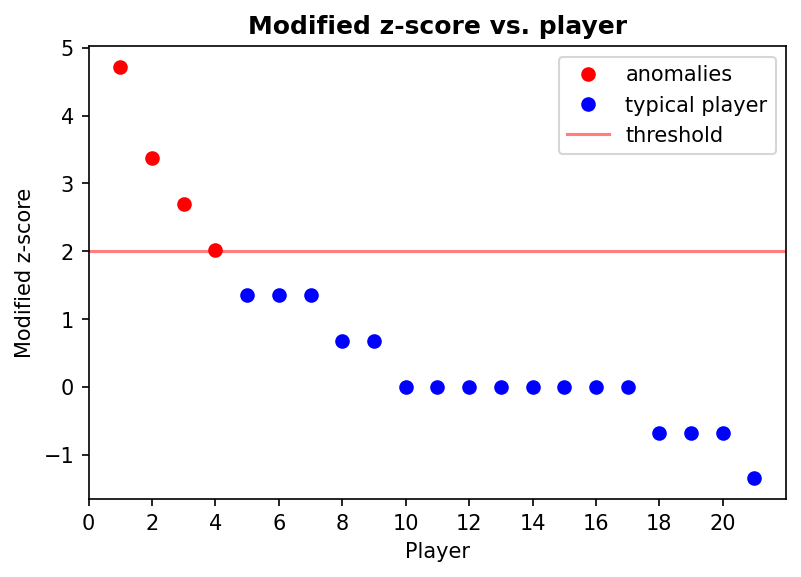

In [ ]:
plot_anomaly_goals_2(top_goals['mod_zscore'], 2)

In [ ]:
mod_zscore_anomalies_players = top_goals[(top_goals['mod_zscore'] > 2)]
mod_zscore_anomalies_players

,Year,Player(s),Goals,zscore,mod_zscore
4,1954,Sándor Kocsis,11,1.839455,3.372454
5,1958,Just Fontaine,13,2.770264,4.721435
7,1966,Eusébio,9,0.908647,2.023472
8,1970,Gerd Müller,10,1.374051,2.697963


In [ ]:
print('The value of MAD is {:.2f}'.format(mad_goals))

The value of MAD is 1.00


In [ ]:
and  k∗MAD
  is 1.48, which is smaller than the standard deviation (2.05). We see that the anomalies have a larger effect on the standard deviation, which depends on the square of the deviation from the mean (MAD depends linearly on the deviation).
Of course, the data for top goal scorers is not normally distributed, so we can't associated probabilities with our scores, but our analysis does show the need to think about the scoring method used with the data.

##Distance-Based Methods
The simplest Nearest Neighbor (NN) method is to take the distance to the k-nearest neighbor as the anomaly score. The next variation is to use the average of the distances to the top-k neighbors as the score.  sklearn provides neighbors.NearestNeighbors to compute the nearest neighbors from a dataset. After fitting, we can use kneighbors() to return the distances and indices of the top-k neighbors. We can use kneighbors_graph() to return the entire connectivity graph (as an array with 1 indicating a link) for the dataset. The graph is a sparse array, but you can operate on it the same as a normal (dense) array. If you must have a normal array, you can use todense() to make it dense.
The idea for the kNN models is
look at the k
 neighbors of each point
assign a score. Roughly, a low score means the point's k
 neighbors are close.
there are multiple ways of determining the score:
maximum of the distances (i.e. distance to k
th nearest neighbor)
average the k
 distances
harmonic mean of the k
 distances.
Use the score to determine if something is an anomaly by using either a threshold or ranking.
We'll start by creating a simple dataset with one anomaly and then plot the data.

In [ ]:
import sklearn.datasets as sk_data
import sklearn.neighbors as neighbors
import sys

np.set_printoptions(suppress=True, precision=4)

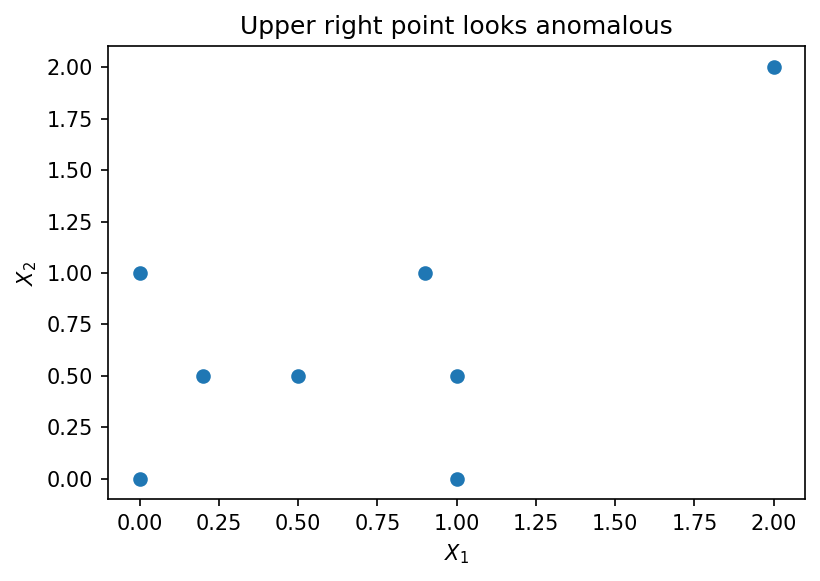

In [ ]:
X = np.array([[0.9, 1], [0, 1], [1, 0], [0, 0], [0.5, 0.5], [0.2, 0.5], [1, 0.5], [2, 2]])

plt.figure(dpi=150)
plt.title('Upper right point looks anomalous')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.plot(X[:, 0], X[:, 1], 'o');

Let's create a function to visualize a query point and its neighbors more explicitly.

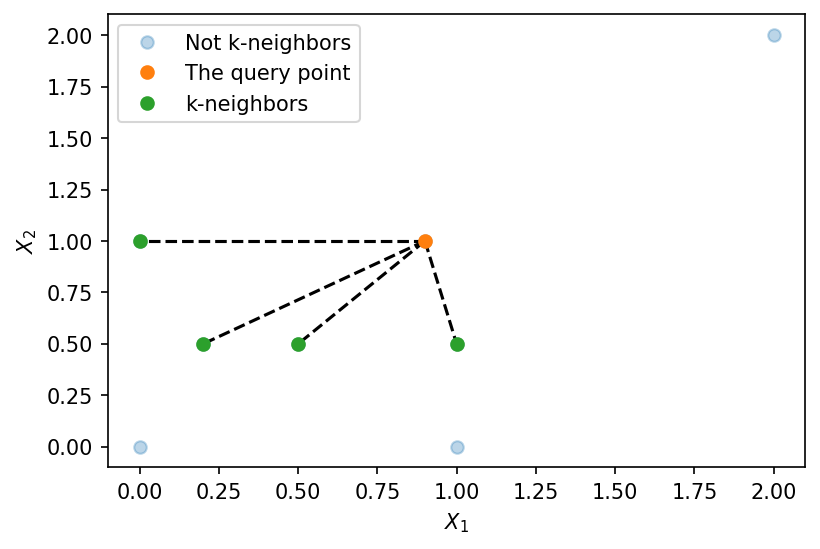

In [ ]:
def plot_point_and_k_neighbors(X, highlight_index, n_neighbors=2):
    "Plots the points in X, and shows the n_neighbors of the highlight_index-th point"
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    dist, index = nn.kneighbors()

    src_pt = X[highlight_index, :]

    plt.figure(dpi=150)
    # draw lines first, so points go on top
    for dest_index in index[highlight_index]:
        dest_pt = X[dest_index, :]
        plt.plot(*list(zip(src_pt, dest_pt)), 'k--')
    plt.plot(X[:, 0], X[:, 1], 'o', label='Not k-neighbors', alpha=0.3)
    plt.plot(*src_pt, 'o', label='The query point')
    plt.plot(X[index[highlight_index], 0], X[index[highlight_index], 1], 'o', label='k-neighbors')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()

# Example of usage
plot_point_and_k_neighbors(X, 0, 4)

Here we can see the 4 points close to the query point (index of 0 in our data) are relatively close. Let's look at the anomalous point in the upper right (this point has an index of 7):

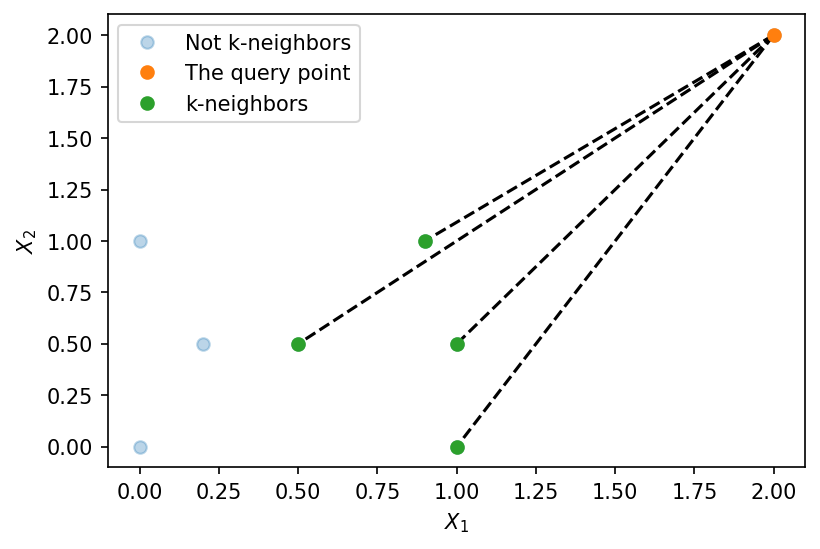

In [ ]:
plot_point_and_k_neighbors(X, 7, n_neighbors=4)

We can see in this case all of the 4-nearest neighbors to our point are far away, so it seems reasonably unambiguous to call this point an anomaly.
Let's add one more point next to the anomaly, and see how choosing "k" and the scoring function affects things.

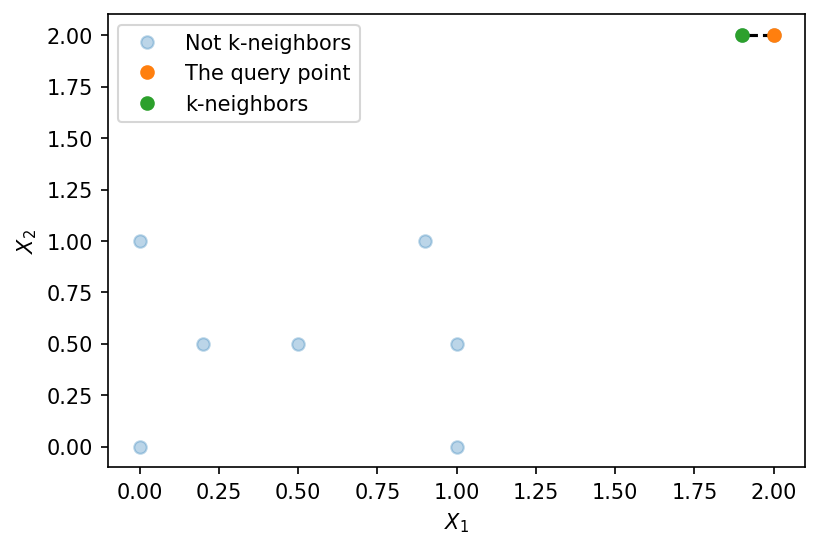

In [ ]:
# Toy dataset with two adjacent anomalies
X2 = np.concatenate([X, [[1.9, 2.0]]])

# Look at nearest neighbor (k=1)
plot_point_and_k_neighbors(X2, 7, n_neighbors=1)

##Observation 1: dependence on  k

The distance between point 7 and the new point is actually quite small—smaller than the distances between any pair of the points in the lower left. If  k=1
 , the two points in the upper right would be the last ones to classified as an anomaly (i.e. they would have the lowest score).
##Observation 2: how to weight distances?
Let's look at the same data set (i.e. with the additional point) but now look at  k=3


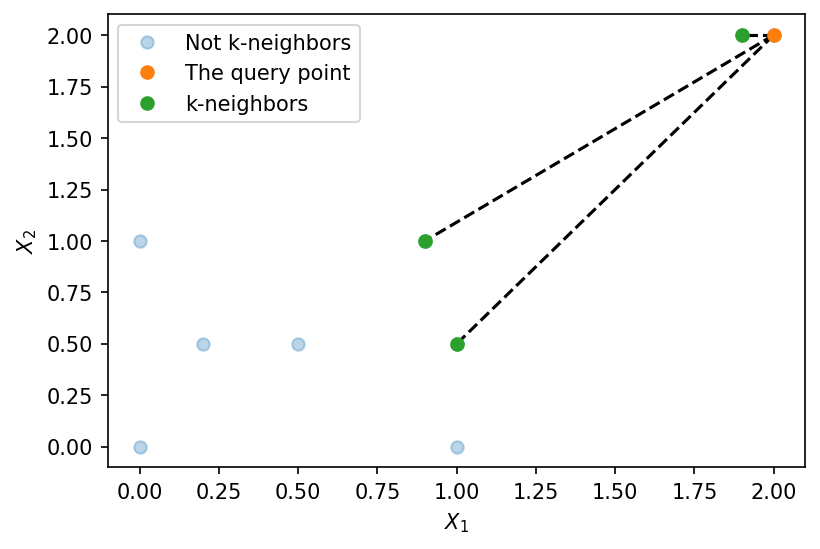

In [ ]:
plot_point_and_k_neighbors(X2, 7, n_neighbors=3)

We see one of the 3 nearest neighbors is very close, but the other two are far away. We need some way of combining these 3 distances into a single score. The three commonly used methods are
Use the longest distance
Use the (arithmetic) mean distance
Use the harmonic mean.
We will implement the longest distance, and assign the arithmetic mean distance and harmonic mean distance as exercises.

##Using the longest distance

In [ ]:
def do_nn_outlier_scores(obs, n_neighbors=1):
    """
    Gives the score of a point as the distance from point to its k-th nearest neighbor.
    Larger score means more likely to be an outlier
    """
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    scores = dists[:,-1]
    return scores

# Test
do_nn_outlier_scores(X2, n_neighbors=3)

array([0.8602, 0.9   , 0.9434, 1.    , 0.6403, 0.5385, 0.5099, 1.8028,
       1.7493])

In [ ]:
def print_ranked_scores(obs, scores):
    scores_and_obs = sorted(zip(scores, obs), key=lambda t: t[0], reverse=True)
    print('Rank  Point\t\tScore')
    print('------------------------------')
    for index, score_ob in enumerate(scores_and_obs):
        score, point = score_ob
        print(f'{index+1:3d}.  {point}\t\t{score:6.4f}')

# Look at the outliers using 3 neighbors

Now look at the anomalies with k=1

In [ ]:

print_ranked_scores(X2, do_nn_outlier_scores(X2, 1))

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.5385
  2.  [0. 0.]		0.5385
  3.  [0.9 1. ]		0.5099
  4.  [1. 0.]		0.5000
  5.  [1.  0.5]		0.5000
  6.  [0.5 0.5]		0.3000
  7.  [0.2 0.5]		0.3000
  8.  [2. 2.]		0.1000
  9.  [1.9 2. ]		0.1000


##Density-Based Methods (Local Outlier Factor)¶

The local outlier factor (LOF) is sklearn has a version available for us to use. Note the the LOF returned by sklearn is the negative of the value we defined in the lecture.
Apply LOF to the collection of points ('X2') we created in section 1.

In [ ]:
import sklearn.neighbors as neighbors
lof = neighbors.LocalOutlierFactor(n_neighbors=3, contamination='auto')
lof.fit(X2)
sk_lof = -lof.negative_outlier_factor_
print_ranked_scores(X2, sk_lof)

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8608
  2.  [1.9 2. ]		1.8293
  3.  [0.2 0.5]		1.2154
  4.  [1.  0.5]		1.2091
  5.  [0. 0.]		1.0333
  6.  [0. 1.]		1.0120
  7.  [1. 0.]		0.9554
  8.  [0.9 1. ]		0.8891
  9.  [0.5 0.5]		0.8272


See values both above and below 1.  we expect the values significantly above 1 to be anomalies.
Compare with the kNN results from before. Note we use the same value of k (=3) for both algorithms.

In [ ]:
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


The two anomalous points are both found either way, but there are differences between the results for the other points.
For completeness, we provide below an explicit implementation of LOF that follows the outline given in the lecture. To check that our algorithm is reasonable, we compare the results for its anomaly score with those of the sklearn version for the cluster blobs ('data').

In [ ]:
def lof_method(obs, n_neighbors=2):
    neigh = neighbors.NearestNeighbors(n_neighbors=2).fit(obs)

    #Return indices of and distances to the neighbors of each point
    topk_dist, my_kneigh = neigh.kneighbors()

    # Create list of distances of furthest (kth) neighbor
    k_dist = topk_dist[:,-1]

    # Reachability distance: maximum of true distance between query neighbor and query point
    # and distance to kth nearest neighbor of query neighbor
    reach = np.maximum(topk_dist, k_dist[my_kneigh])

    # Local reacability density is reciprocal of average reachability distance
    lrd = 1.0 / np.mean(reach, axis=1)

    # Local outlier factor is given by
    # average local density of neighbors / local density of query point
    lrd_ratios = lrd[my_kneigh] / lrd[:, np.newaxis]
    lof = np.mean(lrd_ratios, axis=1)

    return lof